# Introduction to `Gen.jl`

By: John Muchovej

<small>Though this notebook is heavily inspired by the "Introduction to Modeling in Gen" from Gen's tutorial series</small>

In [1]:
# Today's imports
using Gen
using Plots
plotly();

`Gen` are a mix of probabilistic models built using the `Gen` modeling language
along with inference programs written in regular Julia code.

## Probabilistic models as generative functions

`Gen` represents probabilitics models as "generative functions". We can do this
by using Gen's [modeling DSL][modeling]. **This boils down to using writing
typical Julia code, then macroing (annotating) particular sections with Gen's
macros.**

We denote generative functions by prefixing the `@gen` macro to a regular
function definition. This function represents the data-generation process we're
modeling. Randoms choices can be thought of as random variables within a model.

The function below is a probabilistic model of a linear relationship in the 2D
coordinate space $(x, y)$. Given $x$ coordinates, this model randomly chooses a
line in the plane and generates corresponding $y$ values for that each $(x, y)$
is near the line.

Real-world analogies would be modeling the volume of a gas from it's observed
temperature or modeling housing prices as a function of square footage.

[modeling]: https://www.gen.dev/dev/ref/modeling/

In [2]:
@gen function model_linear(xs::Vector{Float64})
    n = length(xs)
    
    # We begin by sampling a slope and an intercept for the line. Before we have seen
    #   the data, we don't know the values of these parameters, so we treat them as
    #   random choices. The distributions they are drawn from represent our prior
    #   beliefs about the parameters: in this case, that neither the slope nor the
    #   intercept will be more than a couple of points away from 0.
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    
    # Given the slope and intercept, we can sample $y$ coordinates for each of the $x$
    #   coordinatoes in our input vector.
    for (idx, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, 0.1), (:y, idx))
    end
    
    # When using Gen, the return value of a model is often unimportant.
    # Here, though, we simply return `n` – the number of points.
    return n
end
;

Our function `model_linear` consumes a `Vector` of $x$-coordinates, so let's
create one below.

In [3]:
xs = collect(-5:1:5) .|> Float64
;

Given `xs`, `model_linear` samples a `:slope` from a
$\mathcal{N}(\mu=0, \sigma=1)$ (a Normal distribution with mean, $\mu=0$, and
standard deviation, $\sigma=1$) and an `:intercept` from a
$\mathcal{N}(\mu=0, \sigma=2)$.

These distributions from which we draw `:slope` and `:intercept` are our
_prior distributions_ over the `:slope` and `:intercept`, respectively.

We then sample $y$-coordinates from each of the $x$ coordinates with $\sigma=0.1$.

Finally, we return the `length(xs)` (or, the number of data points).

In [4]:
n = model_linear(xs)
display(n)

11

However, `n` isn't all that interesting, the values of random choices within
`model_linear` are quite interesting, though. You'll notice the `@trace` macros
attached to each of `:slope`, `:intercept`, and `(:y, idx)`. These are **addresses**
and **`Gen` requires** that they be **unique**.

Addresses can be any valid Julia value, however we will be using `Symbol`s
exclusively, today. In `model_linear`, you'll notice we use one of `Symbol` or
`(Symbol, Integer)`. Though we `@trace` in a `for` loop, because we increment
`idx`, we maintain unique addresses.

`@gen` models actually track each `@trace` (_execution trace_), so we may access
their values even though we don't explicitly return them.

We can run `model_linear` with [`Gen.simulate`][simulate] to obtain it's trace.

[simulate]: https://www.gen.dev/dev/ref/gfi/#Gen.simulate

In [5]:
trace = Gen.simulate(model_linear, (xs, ))
;

`Gen.simulate` takes a function to be executed and a tuple of positional
arguments to the function. Then it returns a `trace`, which is a rather complex
data structure (see below).

In [6]:
display(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##model_linear#257", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:y, 8) => Gen.ChoiceOrCallRecord{Float64}(1.1517697658060726, -0.15054943865430337, NaN, true), (:y, 6) => Gen.ChoiceOrCallRecord{Float64}(3.788870838795794, 1.3777420786494339, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(7.9197551006728775, 1.2015254791929588, NaN, true), (:y, 5) => Gen.ChoiceOrCallRecord{Float64}(5.240051045062564, 1.1954806105674352, NaN, true), :intercept => Gen.ChoiceOrCallRecord{Float64}(3.7780039338639018, -3.3962499293010078, NaN, true), (:y, 4) => Gen.ChoiceOrCallRecord{Float64}(6.648927803605719, 1.141985030144841, NaN, true), (:y, 11) => Gen.ChoiceOrCallRecord{Float64}(-3.2981302579372844, 1.1199043910946915, NaN, true), (:y, 9) => Gen.ChoiceOrCallRecord{Float64}(-

An execution trace tracks many components of a particular run of our function.
For example, we can retrieve the arguments passed to the function using
[`Gen.get_args`][get_args].

[get_args]: https://www.gen.dev/dev/ref/gfi/#Gen.get_args

In [7]:
Gen.get_args(trace)

([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)

We can also retrieve the random choices made. These values are stored in a
`Gen.choicemap` (more on this later). You can use [`Gen.get_choices`][get_choices]
to inspect the random choices made.

[get_choices]: https://www.gen.dev/dev/ref/gfi/#Gen.get_choices

In [8]:
Gen.get_choices(trace)

│
├── (:y, 8) : 1.1517697658060726
│
├── (:y, 6) : 3.788870838795794
│
├── (:y, 3) : 7.9197551006728775
│
├── (:y, 5) : 5.240051045062564
│
├── :intercept : 3.7780039338639018
│
├── (:y, 4) : 6.648927803605719
│
├── (:y, 11) : -3.2981302579372844
│
├── (:y, 9) : -0.4732590985149347
│
├── (:y, 2) : 9.351548817716909
│
├── (:y, 1) : 10.866203513905026
│
├── (:y, 10) : -1.9654222410715694
│
├── :slope : -1.4007012149672209
│
└── (:y, 7) : 2.3737938285258062


We can also access individual choices much like a `Dictionary`.

In [9]:
choices = Gen.get_choices(trace)
choices[:slope]

-1.4007012149672209

However, each execution trace has appropriate functions to allow retrieving
choices directly from the `trace` without needing `Gen.get_choices`.

In [10]:
trace[:slope]

-1.4007012149672209

Additionally, we can inspect the return value of a trace using
[`Gen.get_retval`][get_retval].

[get_retval]: https://www.gen.dev/dev/ref/gfi/#Gen.get_retval

In [11]:
Gen.get_retval(trace)

11

### Aside: Visualizing outputs

It's often useful to visualize traces to better understand the behavior of our
generative functions. `render_line` (below) uses `Plots` to render a trace of
our `model_linear` with options to show $(x, y)$ data points alongside the line.

In [27]:
function render_line(trace, title; show_points=true)
    (xs, ) = Gen.get_args(trace)
    
    slope = trace[:slope]
    intercept = trace[:intercept]
    endx = [minimum(xs), maximum(xs)]
    endy = slope * endx .+ intercept
    scale = [0.9, 1.1]
    
    p = title!(title)
    
    if show_points
        ys = [trace[(:y, idx)] for idx in 1:length(xs)]
        
        p = scatter!(xs, ys, color=:blue, label="$title-data")
    end
    
    p = plot!(endx, endy, color=:purple, label="$title-line")
    p = xlims!((endx .* scale)...)
    p = ylims!((endx .* scale)...)
    
    return p
end
;

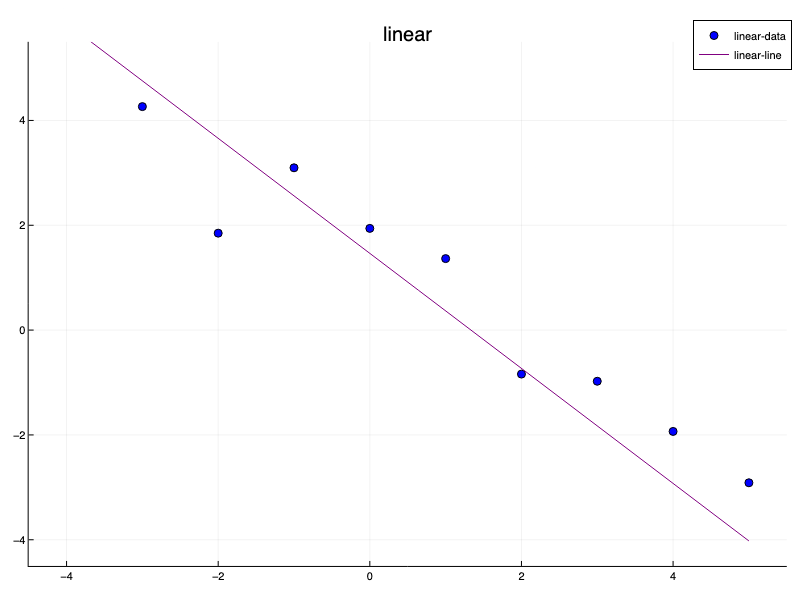

In [28]:
plot(size=(600, 600))
render_line(trace, "linear")

However, we should also have a way of inspecting many runs to better understand
a given function's behavior. We'll use `render_grid` to visualize many runs.

In [31]:
function render_grid(renderer::Function, traces; title="sim", ncols=4, nrows=3)
    plots = []
    for (idx, trace) in enumerate(traces)
        plot(size=(600, 600))
        p = renderer(trace, "$title$idx")
        push!(plots, p)
    end
    
    return plot(
        plots...,
        legend=false,
        size=(ncols * 200, nrows * 200),
    )
end
;

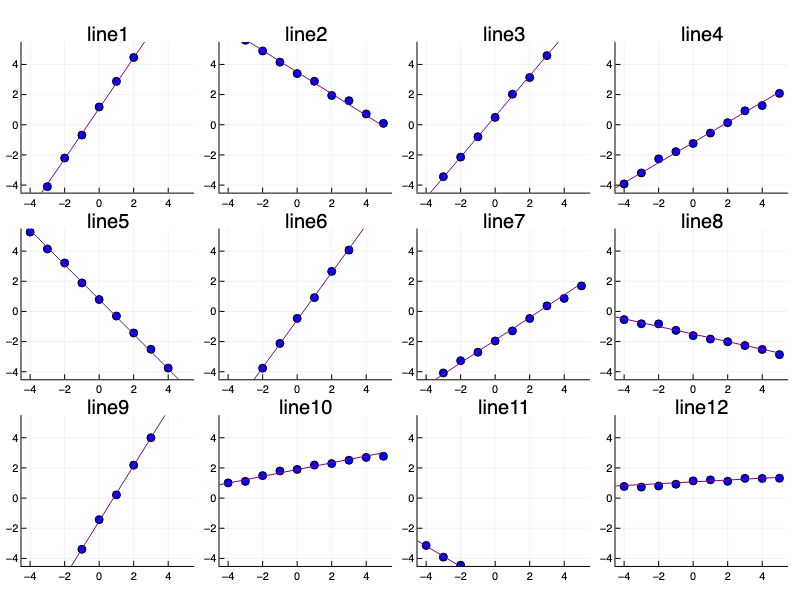

In [32]:
traces = [Gen.simulate(model_linear, (xs, )) for _=1:12]
render_grid(render_line, traces; title="line")

### Exercise: Using the same `@trace` address twice

### Exercise: "Probabilistic" Sine Wave

## Doing posterior inference

We now will provide a dataset of $y$-coordinates and try to draw inferences about the process that generated the data. We begin with the following dataset:

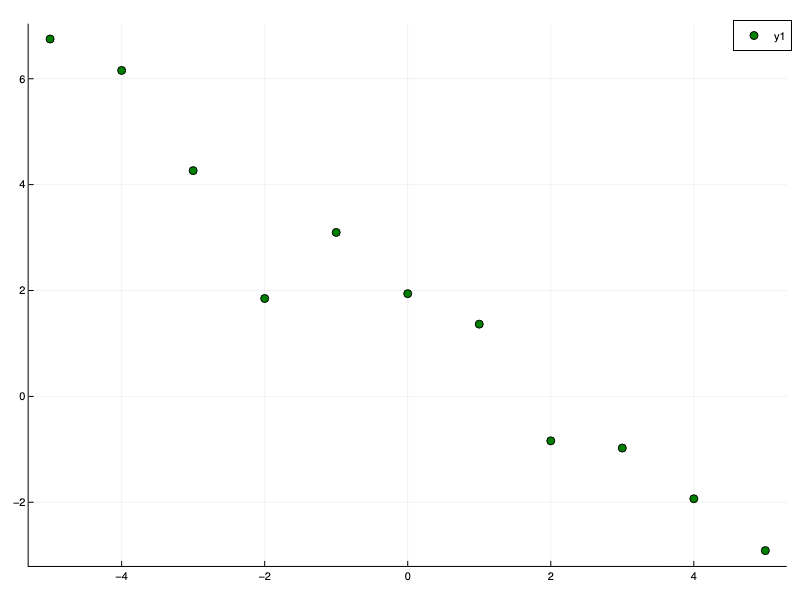

In [16]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];
plot(size=(600, 600))
scatter!(xs, ys, color=:green)

We will now write an _inference program_ (`infer`) that takes a model we assume generated our data, the dataset, and the number of steps we would like to
perform. `infer` will then return a trace of the function that is approximately
sampled from the _posterior distribution_ on traces of the function, given the
observed data.

That is, `infer` will try to find a trace that explains our created dataset
well. We can inspect the trace to find estimates of the `:slope` and
`:intercept` of a line that fits the data.

Functions like `Gen.importance_resampling` expect a `model` and a `choicemap`
representing our dataset and relating it to our `model`.
A `choicemap` will map the random choice addresses in `model_linear` to values
from our dataset `ys`. For example, the 4th value in our dataset (`y[4]`) will
be tied to `(:y, 4)`.

In [17]:
function infer(model, xs::Vector, ys::Vector, steps::Int64, args...; kwargs...)
    # Create a `choicemap` that models addresses `(:y, i)` to observed values `ys[i]`.
    #   We leave `:slope` and `:intercept` unconstracted because we want them to be
    #   inferred.
    observations = Gen.choicemap()
    for (idx, y) in enumerate(ys)
        observations[(:y, idx)] = y
    end
    
    # Call `importance_resampling` to obtain a likely trace consistent with our
    #   observations.
    (trace, _) = Gen.importance_resampling(model, (xs, args..., kwargs...), observations, steps)
    return trace
end;

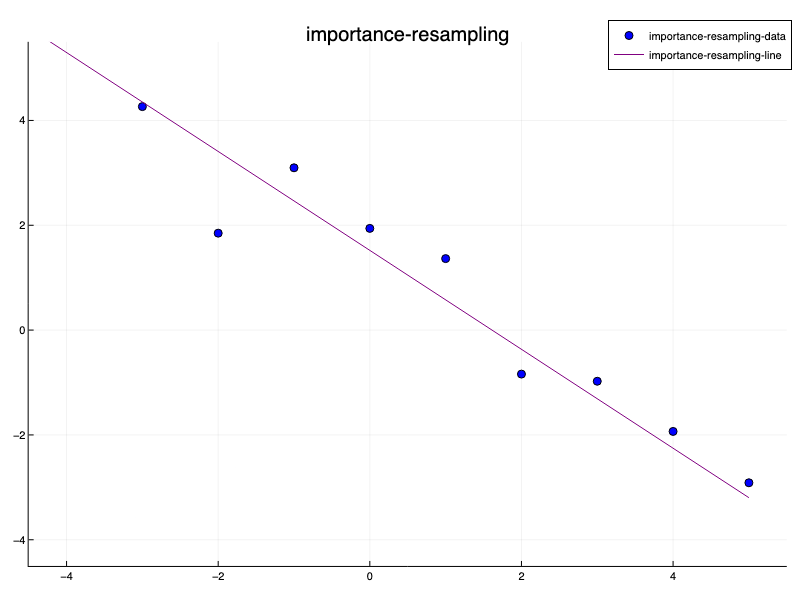

In [33]:
trace = infer(model_linear, xs, ys, 100)
plot(size=(600, 600))
render_line(trace, "importance-resampling")

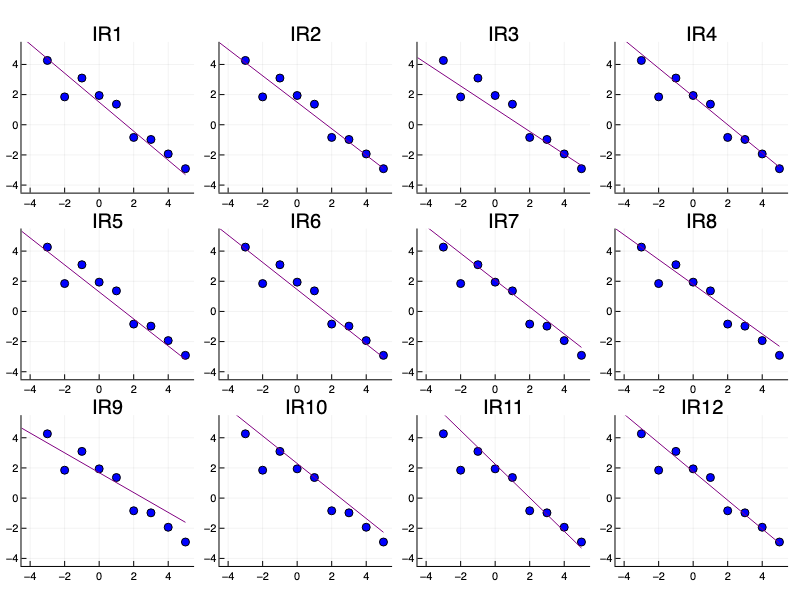

In [35]:
traces = [infer(model_linear, xs, ys, 100) for _=1:12]
plot(size=(800, 600))
render_grid(render_line, traces, title="IR")

We can see that there's some uncertainty about the line which best generates our
data. With our limited data, we can't be 100% sure where the line is. However,
we might get a better sense for the variability in the _posterior distribution_
by visualizing all the traces in one plot, rather than in a grid.

Each trace will have the same observed data points, so we'll only plot those
once, based on the values of the first trace.

In [37]:
function render_overlay(renderer::Function, traces; title="sim")
    (xs, ) = Gen.get_args(traces[1])
    prev_xs = zeros(size(xs))
    
    for trace in traces
        (curr_xs, ) = Gen.get_args(trace)
        renderer(trace, title; show_points=(prev_xs != curr_xs))
        (prev_xs, ) = Gen.get_args(trace)
    end
    return plot!()
end
;

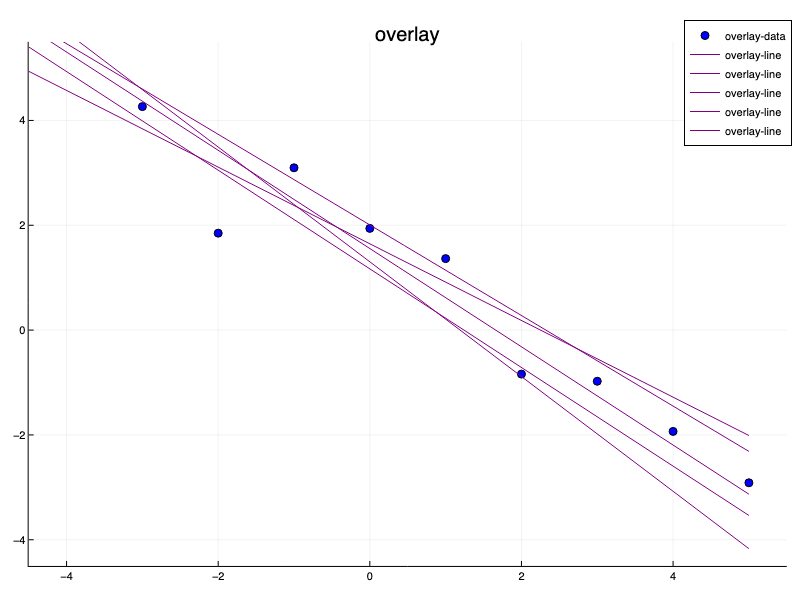

In [38]:
traces = [infer(model_linear, xs, ys, 100) for _=1:5]
plot(size=(600, 600))
render_overlay(render_line, traces; title="overlay")

### Exercise: Run `model_linear` with `1`, `10`, and `1000` steps

## Predicting new data

We can use `Gen.generate` to generate a trace where certain random choices are
constrained to given values. This is done by way of a `Gen.choicemap`.

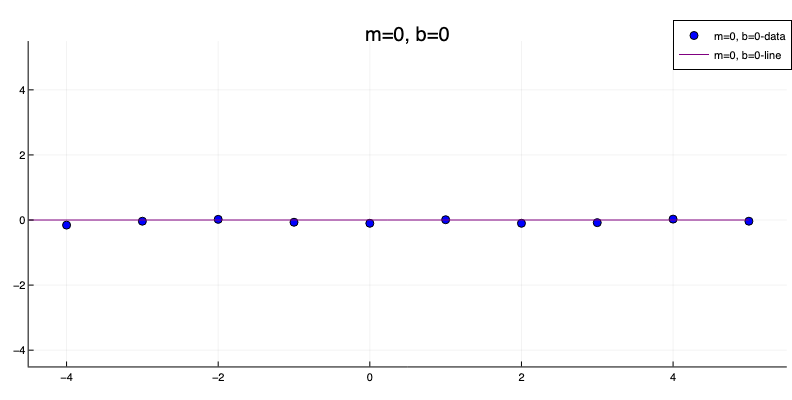

In [39]:
constraints = Gen.choicemap()
constraints[:slope] = 0.
constraints[:intercept] = 0
(trace, _) = Gen.generate(model_linear, (xs, ), constraints)

plot(size(600, 600))
render_line(trace, "m=0, b=0")

Note that the points above are still generated randomly. _Run the cell a few
times to verify this._

We can use this ability to constrain executions to predict the values of the
$y$-coordinates at new $x$-coordinates by running new executions of the `model`.
Let's inspect the `predict` function below. It takes a `trace` and a `Vector` of
new $x$-coordinates, then returns a `Vector` of predicted $y$-coordinates
corresponding to the `new_xs`.

The `addresses` parameter allows us to use `predict` with an arbitrary model.

In [40]:
function predict(model, trace, new_xs::Vector{Float64}, addresses)
    # Copy parameter values from the inferred `trace` into a new `choicemap`.
    constraints = Gen.choicemap()
    for address in addresses
        constraints[address] = trace[address]
    end
    
    # Run the model with new x coordinates, and parameters fixed to inferred values
    (new_trace, _) = Gen.generate(model, (new_xs, ), constraints)
    
    # Extract y values and return them
    return map(idx -> new_trace[(:y, idx)], 1:length(new_xs))
end
;

The cell below defines a composite function that performs inference on an
observed dataset `(xs, ys)`, then runs `predict` to generate predicted
$y$-coordinates. This process generates `num_traces`, returning a `Matrix` of
predicted $y$-coordinates.

In [41]:
function infer_and_predict(model, xs::Vector, ys::Vector, new_xs::Vector, addresses, num_traces::Int, steps::Int)
    pred_ys = []
    for _=1:num_traces
        trace = infer(model, xs, ys, steps)
        push!(pred_ys, predict(model, trace, new_xs, addresses))
    end
    return pred_ys
end
;

In [42]:
function plot_predictions(xs::Vector, ys::Vector, new_xs::Vector, pred_ys::Vector)
    p = plot(size=(600, 600))
    for pred_y in pred_ys
        p = scatter!(new_xs, pred_y, color=:black, alpha=0.3, legend=false)
    end
    p = scatter!(xs, ys, color=:red)
    return p
end
;

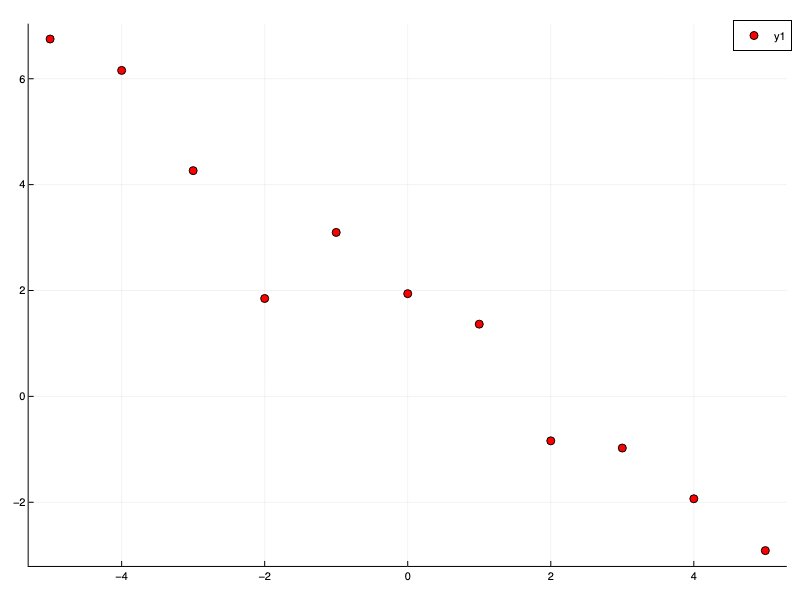

In [44]:
scatter(xs, ys, color=:red, size=(600, 600))

We can use the inferred values of the paramters to predict $y$ coordinates for
$x$ coordinates from $[5, 10]$ (from which data was not observed). We can also
predict data within a new $[-5, 5]$ to compare against our originally observed
data.

Predicting new data from inferred parameters, then comparing this new data to
the observed data is the core idea behind _posterior predictive check_. We won't
provide a rigorous overview behind techniques for checking the quality of a
model, but intent to provide a high-level intuition.

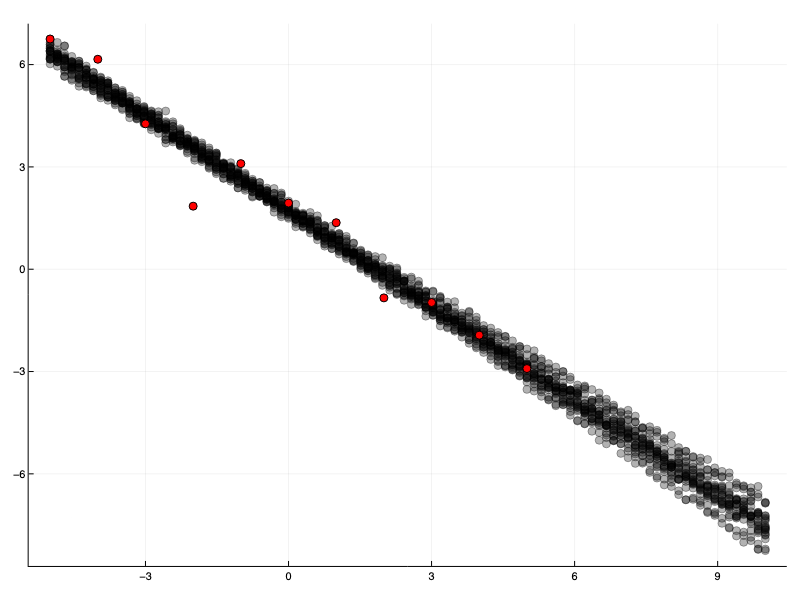

In [45]:
new_xs = collect(range(-5, 10; length=100))
pred_ys = infer_and_predict(model_linear, xs, ys, new_xs, [:slope, :intercept], 20, 1_000)
plot_predictions(xs, ys, new_xs, pred_ys)

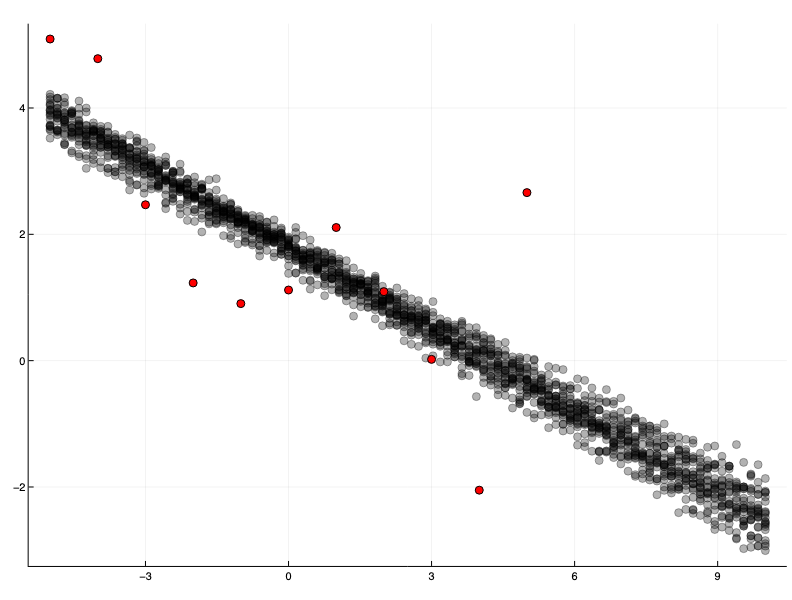

In [46]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031]

pred_ys = infer_and_predict(model_linear, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1_000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)